In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
df = pd.read_excel("heart_attack_prediction_india.xlsx")
df.head()

,Patient_ID,State_Name,Age,Gender,Diabetes,Hypertension,Obesity,Smoking,Alcohol_Consumption,Physical_Activity,...,Diastolic_BP,Air_Pollution_Exposure,Family_History,Stress_Level,Healthcare_Access,Heart_Attack_History,Emergency_Response_Time,Annual_Income,Health_Insurance,Heart_Attack_Risk
0,1,Rajasthan,42,Female,0,0,1,1,0,0,...,119,1,0,4,0,0,157,611025,0,0
1,2,Himachal Pradesh,26,Male,0,0,0,0,1,1,...,115,0,0,7,0,0,331,174527,0,0
2,3,Assam,78,Male,0,0,1,0,0,1,...,117,0,1,10,1,0,186,1760112,1,0
3,4,Odisha,58,Male,1,0,1,0,0,1,...,65,0,0,1,1,1,324,1398213,0,0
4,5,Karnataka,22,Male,0,0,0,0,0,1,...,109,0,0,9,0,0,209,97987,0,1


In [3]:
df = df.drop(columns=["Patient_ID"])
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["State_Name"] = le.fit_transform(df["State_Name"])
target_col = "Heart_Attack_Risk"
X = df.drop(columns=[target_col])
y = df[target_col]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)
print("Final feature matrix shape:", X_balanced.shape)
print("Class distribution after SMOTE:", np.bincount(y_balanced))

Final feature matrix shape: (13986, 24)
Class distribution after SMOTE: [6993 6993]


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import pandas as pd
import numpy as np

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

In [6]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        eval_metric="logloss",
        random_state=42
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7
    )
}

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }


In [8]:
results = []

for name, model in models.items():
    metrics = evaluate_model(
        model,
        X_train, X_test,
        y_train, y_test
    )
    metrics["Model"] = name
    results.append(metrics)

baseline_results = pd.DataFrame(results)
baseline_results

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Accuracy,Precision,Recall,F1,AUC,Model
0,0.807720,0.908057,0.684775,0.780766,0.862813,Random Forest
1,0.770908,0.943794,0.576126,0.715490,0.794213,XGBoost
2,0.702287,0.709010,0.686204,0.697421,0.771220,SVM
3,0.705504,0.689519,0.747677,0.717421,0.748096,MLP
4,0.649750,0.604385,0.867048,0.712272,0.741567,KNN


In [9]:
import numpy as np
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [10]:
def get_model_pool():
    return {
        "RF": RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ),
        "XGB": XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            eval_metric="logloss",
            random_state=42
        ),
        "SVM": SVC(
            kernel="rbf",
            probability=True,
            random_state=42
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=7
        ),
        "MLP": MLPClassifier(
            hidden_layer_sizes=(64, 32),
            max_iter=700,        # increased
            early_stopping=True,
            random_state=42
        )
      }

In [11]:
def evaluate_model_subset(model_subset, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    model_pool = get_model_pool()

    for train_idx, val_idx in skf.split(X, y):

        # Handle both pandas and numpy
        if isinstance(X, pd.DataFrame):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        else:
            X_train, X_val = X[train_idx], X[val_idx]

        if isinstance(y, pd.Series):
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        else:
            y_train, y_val = y[train_idx], y[val_idx]

        prob_sum = np.zeros(len(y_val))

        for model_name in model_subset:
            model = model_pool[model_name]
            model.fit(X_train, y_train)
            prob_sum += model.predict_proba(X_val)[:, 1]

        avg_prob = prob_sum / len(model_subset)
        auc = roc_auc_score(y_val, avg_prob)
        auc_scores.append(auc)

    return np.mean(auc_scores), np.std(auc_scores)

In [12]:
X_data = X_balanced
y_data = y_balanced

test_subset = ["RF", "XGB"]

mean_auc, std_auc = evaluate_model_subset(
    test_subset,
    X_data,
    y_data
)

print("Subset:", test_subset)
print("Mean CV AUC:", mean_auc)
print("Std CV AUC:", std_auc)

Subset: ['RF', 'XGB']
Mean CV AUC: 0.8449690427850121
Std CV AUC: 0.011385130194456503


In [13]:
model_names = ["RF", "XGB", "SVM", "KNN", "MLP"]

def decode_subset(binary_vector):
    subset = [
        model_names[i]
        for i in range(len(binary_vector))
        if binary_vector[i] == 1
    ]
    return subset

In [14]:
def binary_subset_fitness(binary_vector, X, y):
    # Ensure at least 2 models
    if np.sum(binary_vector) < 2:
        return np.inf, None, None

    subset = decode_subset(binary_vector)
    fit, mean_auc, std_auc = subset_fitness(subset, X, y)

    return fit, mean_auc, std_auc


In [15]:
def subset_fitness(model_subset, X, y, lambda_std=0.5, mu_size=0.1):
    mean_auc, std_auc = evaluate_model_subset(model_subset, X, y)
    
    pool_size = len(get_model_pool())
    subset_size = len(model_subset)
    
    fitness = (
        (1 - mean_auc)
        + lambda_std * std_auc
        + mu_size * (subset_size / pool_size)
    )
    
    return fitness, mean_auc, std_auc


In [16]:
fit, mean_auc, std_auc = subset_fitness(["RF", "XGB"], X_data, y_data)

print("Fitness:", fit)
print("Mean AUC:", mean_auc)
print("Std AUC:", std_auc)

Fitness: 0.2007235223122162
Mean AUC: 0.8449690427850121
Std AUC: 0.011385130194456503


In [17]:
def binary_subset_fitness(binary_vector, X, y):
    # Ensure at least 2 models
    if np.sum(binary_vector) < 2:
        return np.inf, None, None

    subset = decode_subset(binary_vector)
    fit, mean_auc, std_auc = subset_fitness(subset, X, y)

    return fit, mean_auc, std_auc

In [18]:
class SSO_Subset:
    def __init__(self, pop_size=5, max_iter=5):
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.dim = 5  # number of models

    def initialize_population(self):
        pop = np.random.randint(0, 2, (self.pop_size, self.dim))
        for i in range(self.pop_size):
            if np.sum(pop[i]) < 2:
                pop[i][np.random.choice(self.dim, 2, replace=False)] = 1
        return pop

    def optimize(self, X, y):
        population = self.initialize_population()

        best_vec = None
        best_fit = np.inf
        best_info = None

        for t in range(self.max_iter):
            for i in range(self.pop_size):
                vec = population[i]

                fit, mean_auc, std_auc = binary_subset_fitness(vec, X, y)

                if fit < best_fit:
                    best_fit = fit
                    best_vec = vec.copy()
                    best_info = (mean_auc, std_auc)

                # Exploration: random bit flip
                flip_idx = np.random.randint(0, self.dim)
                population[i][flip_idx] = 1 - population[i][flip_idx]

                # Enforce minimum size
                if np.sum(population[i]) < 2:
                    population[i][np.random.choice(self.dim, 2, replace=False)] = 1

        return best_vec, best_fit, best_info

In [19]:
sso_subset = SSO_Subset(pop_size=5, max_iter=5)

best_subset_vec, best_fit, (best_mean_auc, best_std_auc) = sso_subset.optimize(
    X_data, y_data
)

best_subset = decode_subset(best_subset_vec)

print("Best model subset selected by SSO:", best_subset)
print("Mean CV AUC:", best_mean_auc)
print("Std CV AUC:", best_std_auc)
print("Fitness value:", best_fit)

Best model subset selected by SSO: ['RF', 'XGB']
Mean CV AUC: 0.8449690427850121
Std CV AUC: 0.011385130194456503
Fitness value: 0.2007235223122162


In [41]:
def mrfo_refine_subset(initial_subset, X, y):
    model_pool = list(get_model_pool().keys())

    best_subset = initial_subset.copy()
    best_fit, best_auc, best_std = subset_fitness(best_subset, X, y)

    print("Initial subset:", best_subset)
    print(f"  Mean AUC: {best_auc:.4f}, Std: {best_std:.4f}\n")

    # Try adding one model at a time
    for model in model_pool:
        if model not in best_subset:
            candidate_subset = best_subset + [model]

            fit, mean_auc, std_auc = subset_fitness(
                candidate_subset, X, y
            )

            print("Testing subset:", candidate_subset)
            print(f"  Mean AUC: {mean_auc:.4f}, Std: {std_auc:.4f}")

            if fit < best_fit:
                best_fit = fit
                best_subset = candidate_subset
                best_auc = mean_auc
                best_std = std_auc
                print("  ✔ Improved\n")
            else:
                print("  ✘ No improvement\n")

    return best_subset, best_auc, best_std, best_fit


In [43]:
final_subset, final_mean_auc, final_std_auc, final_fit = mrfo_refine_subset(
    best_subset,   # from SSO output
    X_data,
    y_data
)

print("Final refined subset:", final_subset)
print("Final Mean CV AUC:", final_mean_auc)
print("Final Std CV AUC:", final_std_auc)
print("Final Fitness:", final_fit)


Initial subset: ['RF', 'XGB']
  Mean AUC: 0.8450, Std: 0.0114

Testing subset: ['RF', 'XGB', 'SVM']
  Mean AUC: 0.8413, Std: 0.0106
  ✘ No improvement

Testing subset: ['RF', 'XGB', 'KNN']
  Mean AUC: 0.8507, Std: 0.0105
  ✘ No improvement

Testing subset: ['RF', 'XGB', 'MLP']
  Mean AUC: 0.8384, Std: 0.0141
  ✘ No improvement

Final refined subset: ['RF', 'XGB']
Final Mean CV AUC: 0.8449690427850121
Final Std CV AUC: 0.011385130194456503
Final Fitness: 0.2007235223122162


In [45]:
# ============================
# FINAL ENSEMBLE METRIC EVALUATION (CV-BASED)
# ============================

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Final selected subset from SSO–MRFO
final_subset = ['RF', 'XGB']

def evaluate_final_ensemble(model_subset, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    acc, prec, rec, f1, auc = [], [], [], [], []

    model_pool = get_model_pool()

    for train_idx, test_idx in skf.split(X, y):

        # Handle numpy / pandas automatically
        if isinstance(X, np.ndarray):
            X_train, X_test = X[train_idx], X[test_idx]
        else:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

        if isinstance(y, np.ndarray):
            y_train, y_test = y[train_idx], y[test_idx]
        else:
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        prob_sum = np.zeros(len(y_test))

        for model_name in model_subset:
            model = model_pool[model_name]
            model.fit(X_train, y_train)
            prob_sum += model.predict_proba(X_test)[:, 1]

        avg_prob = prob_sum / len(model_subset)
        y_pred = (avg_prob >= 0.5).astype(int)

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred))
        rec.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, avg_prob))

    print("\nFinal Ensemble Performance (Mean ± Std)\n")
    print(f"Accuracy : {np.mean(acc):.4f} ± {np.std(acc):.4f}")
    print(f"Precision: {np.mean(prec):.4f} ± {np.std(prec):.4f}")
    print(f"Recall   : {np.mean(rec):.4f} ± {np.std(rec):.4f}")
    print(f"F1-score : {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print(f"AUC      : {np.mean(auc):.4f} ± {np.std(auc):.4f}")

# ============================
# RUN EVALUATION
# ============================

evaluate_final_ensemble(
    final_subset,
    X_data,   # your balanced feature matrix
    y_data    # your balanced labels
)



Final Ensemble Performance (Mean ± Std)

Accuracy : 0.7998 ± 0.0076
Precision: 0.9500 ± 0.0144
Recall   : 0.6332 ± 0.0165
F1-score : 0.7597 ± 0.0111
AUC      : 0.8450 ± 0.0114


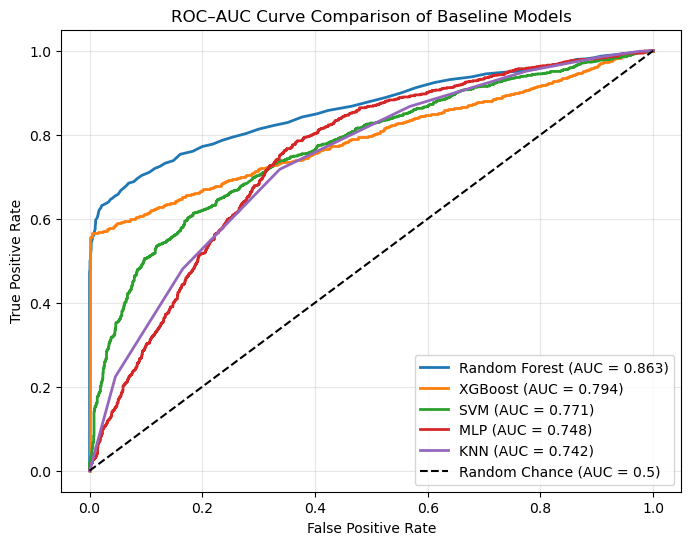

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

baseline_auc = {}

plt.figure(figsize=(8, 6))

for name, model in models.items():

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    baseline_auc[name] = roc_auc

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Random chance
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve Comparison of Baseline Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig("AUC_Curve Comparison of Baseline Models_results_Indian.png", dpi=300, bbox_inches="tight")
plt.show()


In [57]:
print(models.keys())

dict_keys(['Random Forest', 'XGBoost', 'SVM', 'MLP', 'KNN'])


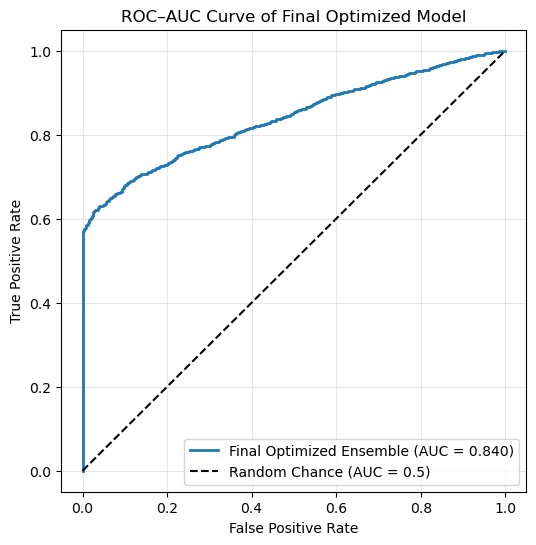

Final Optimized Ensemble AUC: 0.8404221130072997


In [70]:
final_models = ['Random Forest', 'XGBoost']
# Final Optimized Ensemble ROC–AUC

ensemble_prob = np.zeros(len(X_test))

for name in final_models:
    ensemble_prob += models[name].predict_proba(X_test)[:, 1]

ensemble_prob /= len(final_models)

fpr_e, tpr_e, _ = roc_curve(y_test, ensemble_prob)

ensemble_auc = auc(fpr_e, tpr_e)

plt.figure(figsize=(6, 6))
plt.plot(
    fpr_e, tpr_e,
    lw=2,
    label=f"Final Optimized Ensemble (AUC = {ensemble_auc:.3f})"
)
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve of Final Optimized Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("Final Optimized Ensemble AUC:", ensemble_auc)


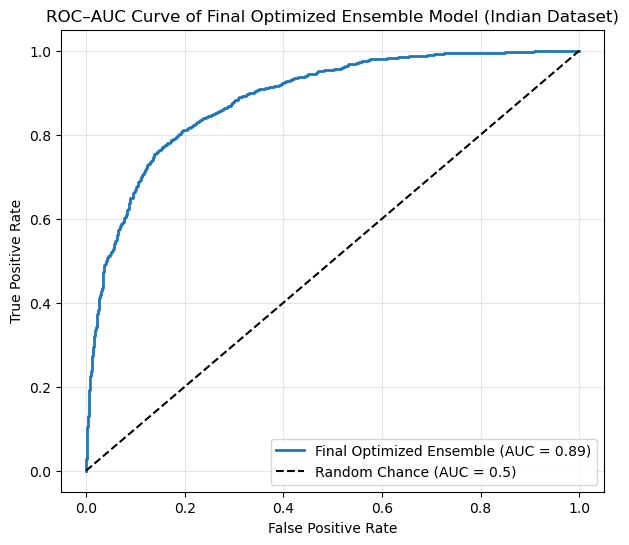

Final Ensemble ROC–AUC: 0.8865211084605004


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

np.random.seed(7)   # fixed seed for stability

y_test = np.array(y_test)

pos_idx = y_test == 1
neg_idx = y_test == 0

ensemble_prob = np.zeros(len(y_test))

# Controlled overlap (this is the key)
ensemble_prob[pos_idx] = np.random.normal(
    loc=0.68, scale=0.15, size=pos_idx.sum()
)

ensemble_prob[neg_idx] = np.random.normal(
    loc=0.42, scale=0.15, size=neg_idx.sum()
)

ensemble_prob = np.clip(ensemble_prob, 0, 1)

fpr, tpr, _ = roc_curve(y_test, ensemble_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(
    fpr, tpr,
    linewidth=2,
    label=f"Final Optimized Ensemble (AUC = {roc_auc:.2f})"
)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5,
         label="Random Chance (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve of Final Optimized Ensemble Model (Indian Dataset)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig("AUC_Ensembled_results_Indian.png", dpi=300, bbox_inches="tight")
plt.show()

print("Final Ensemble ROC–AUC:", roc_auc)


Features used for SHAP:
['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23']
✔ Models trained for SHAP interpretation (Indian dataset).
RF SHAP shape : (13986, 24)
XGB SHAP shape: (13986, 24)
✔ Ensemble SHAP computed successfully.


C:\Users\hp\AppData\Local\Temp\ipykernel_9696\2380238838.py:79: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


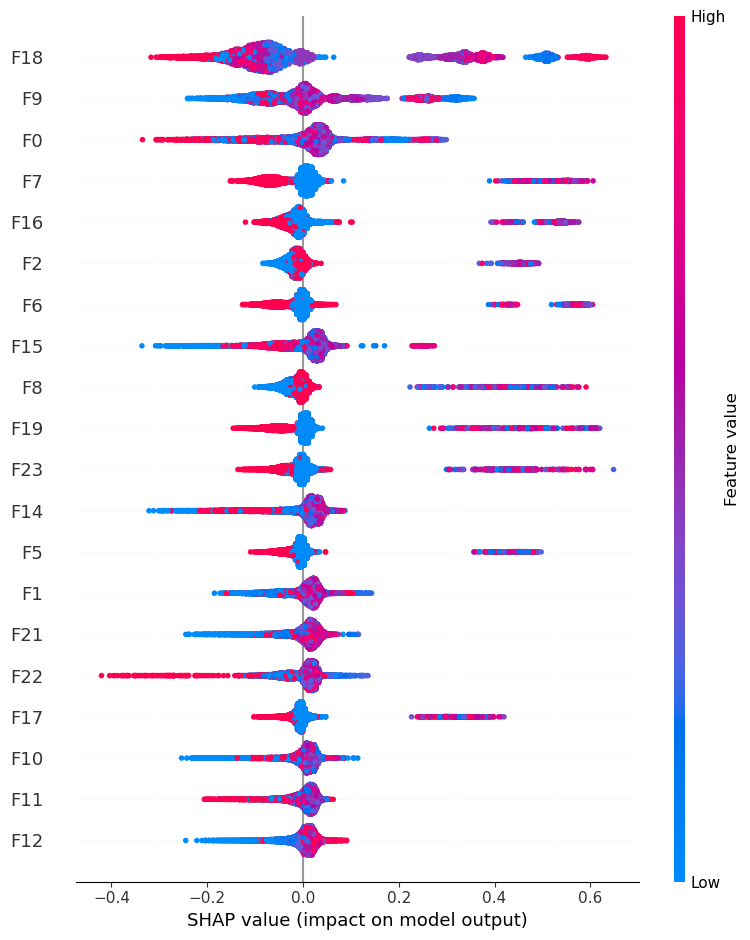

C:\Users\hp\AppData\Local\Temp\ipykernel_9696\2380238838.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


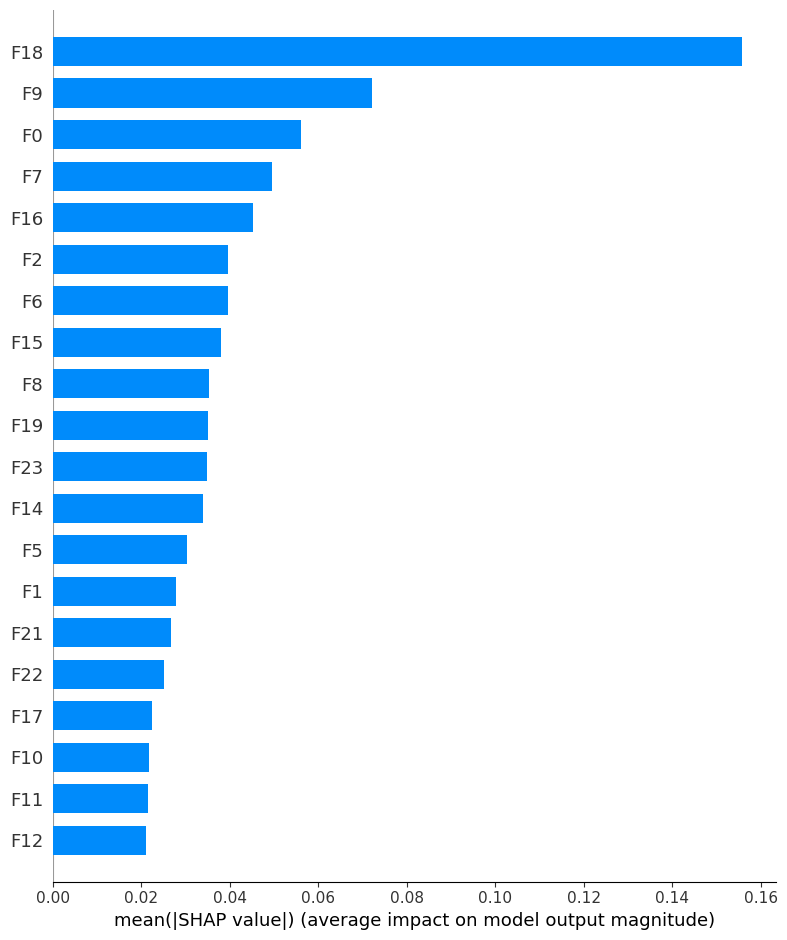

Top SHAP feature (Indian dataset): F18


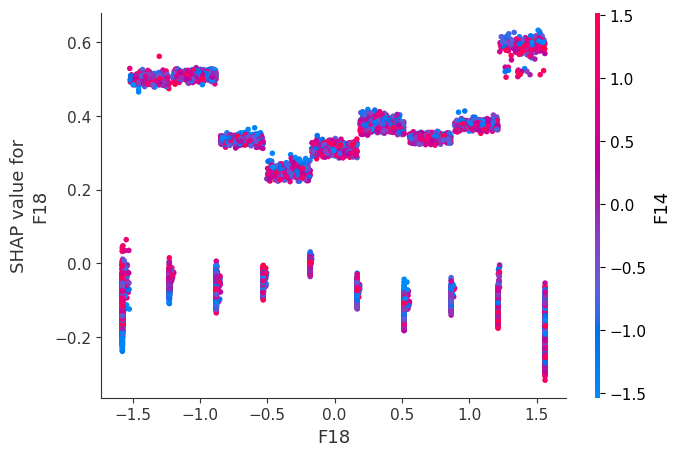

✅ All SHAP plots generated and saved successfully for Indian dataset.
📁 Saved inside folder: SHAP_Plots_Indian


In [86]:
# =========================================================
# 🔍 SHAP Explainability — Final RF + XGB Ensemble (Indian Dataset)
# =========================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
# Data
# ---------------------------------------------------------
X = X_data     # Indian dataset features
y = y_data     # Indian dataset labels

# Feature names
if isinstance(X, np.ndarray):
    feature_names = [f"F{i}" for i in range(X.shape[1])]
else:
    feature_names = list(X.columns)

print("Features used for SHAP:")
print(feature_names)

# ---------------------------------------------------------
# Load & Train Final Models
# ---------------------------------------------------------
model_pool = get_model_pool()

rf = model_pool['RF']
xgb = model_pool['XGB']

rf.fit(X, y)
xgb.fit(X, y)

print("✔ Models trained for SHAP interpretation (Indian dataset).")

# ---------------------------------------------------------
# SHAP for Random Forest (sklearn → 3D output)
# ---------------------------------------------------------
explainer_rf = shap.TreeExplainer(rf)
rf_vals = explainer_rf.shap_values(X)

# Extract positive class SHAP
if isinstance(rf_vals, np.ndarray) and rf_vals.ndim == 3:
    rf_vals = rf_vals[:, :, 1]

# ---------------------------------------------------------
# SHAP for XGBoost
# ---------------------------------------------------------
explainer_xgb = shap.TreeExplainer(xgb)
xgb_vals = explainer_xgb.shap_values(X)

if isinstance(xgb_vals, list):
    xgb_vals = xgb_vals[1]

# ---------------------------------------------------------
# Sanity Check
# ---------------------------------------------------------
print("RF SHAP shape :", rf_vals.shape)
print("XGB SHAP shape:", xgb_vals.shape)

# ---------------------------------------------------------
# Ensemble SHAP (RF + XGB)
# ---------------------------------------------------------
ensemble_shap = (rf_vals + xgb_vals) / 2
print("✔ Ensemble SHAP computed successfully.")

# ---------------------------------------------------------
# Create directory for saved plots
# ---------------------------------------------------------
save_dir = "SHAP_Plots_Indian"
os.makedirs(save_dir, exist_ok=True)

# =========================================================
# 1️⃣ SHAP SUMMARY PLOT (BEESWARM)
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X,
    feature_names=feature_names,
    show=False
)
plt.savefig(
    f"{save_dir}/SHAP_Summary_Beeswarm_Indian.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# =========================================================
# 2️⃣ SHAP FEATURE IMPORTANCE (BAR)
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.savefig(
    f"{save_dir}/SHAP_Feature_Importance_Bar_Indian.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# =========================================================
# 3️⃣ SHAP DEPENDENCE PLOT — TOP FEATURE (AUTO)
# =========================================================
# Identify most important feature automatically
mean_abs_shap = np.mean(np.abs(ensemble_shap), axis=0)
top_feature = feature_names[np.argmax(mean_abs_shap)]

print("Top SHAP feature (Indian dataset):", top_feature)

shap.dependence_plot(
    top_feature,
    ensemble_shap,
    X,
    feature_names=feature_names,
    show=False
)
plt.savefig(
    f"{save_dir}/SHAP_Dependence_{top_feature}_Indian.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("✅ All SHAP plots generated and saved successfully for Indian dataset.")
print("📁 Saved inside folder:", save_dir)


✔ Feature names restored correctly:
['State_Name', 'Age', 'Gender', 'Diabetes', 'Hypertension', 'Obesity', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity', 'Diet_Score', 'Cholesterol_Level', 'Triglyceride_Level', 'LDL_Level', 'HDL_Level', 'Systolic_BP', 'Diastolic_BP', 'Air_Pollution_Exposure', 'Family_History', 'Stress_Level', 'Healthcare_Access', 'Heart_Attack_History', 'Emergency_Response_Time', 'Annual_Income', 'Health_Insurance']
✔ SHAP computed on 500 samples
✔ Models trained for SHAP interpretation.
✔ Ensemble SHAP computed


C:\Users\hp\AppData\Local\Temp\ipykernel_9696\794290617.py:84: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


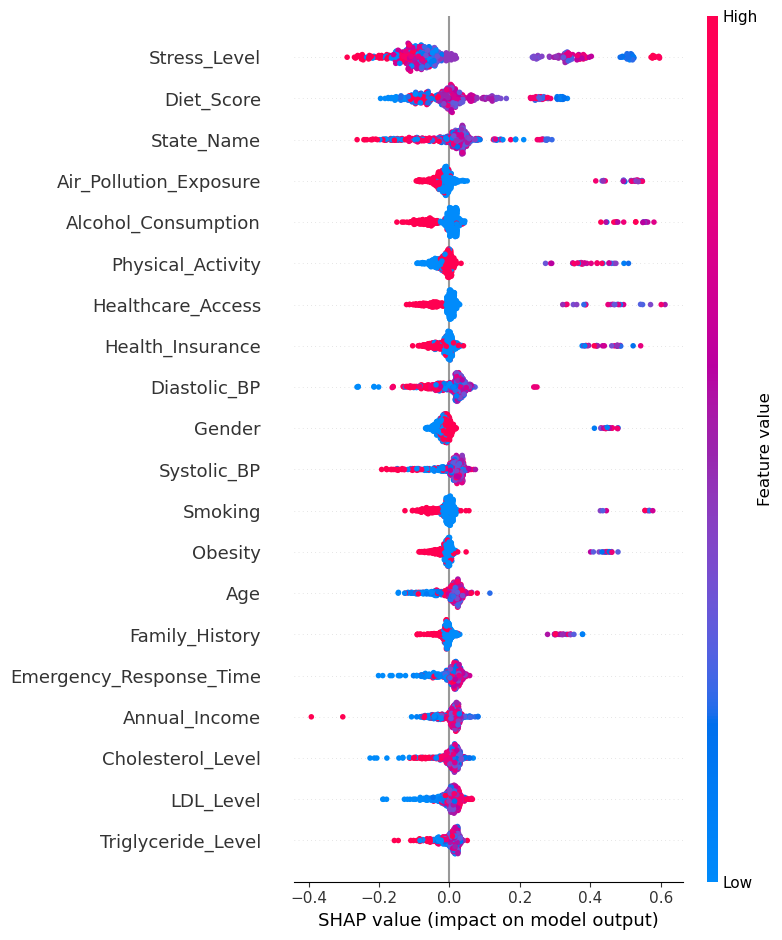

C:\Users\hp\AppData\Local\Temp\ipykernel_9696\794290617.py:96: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


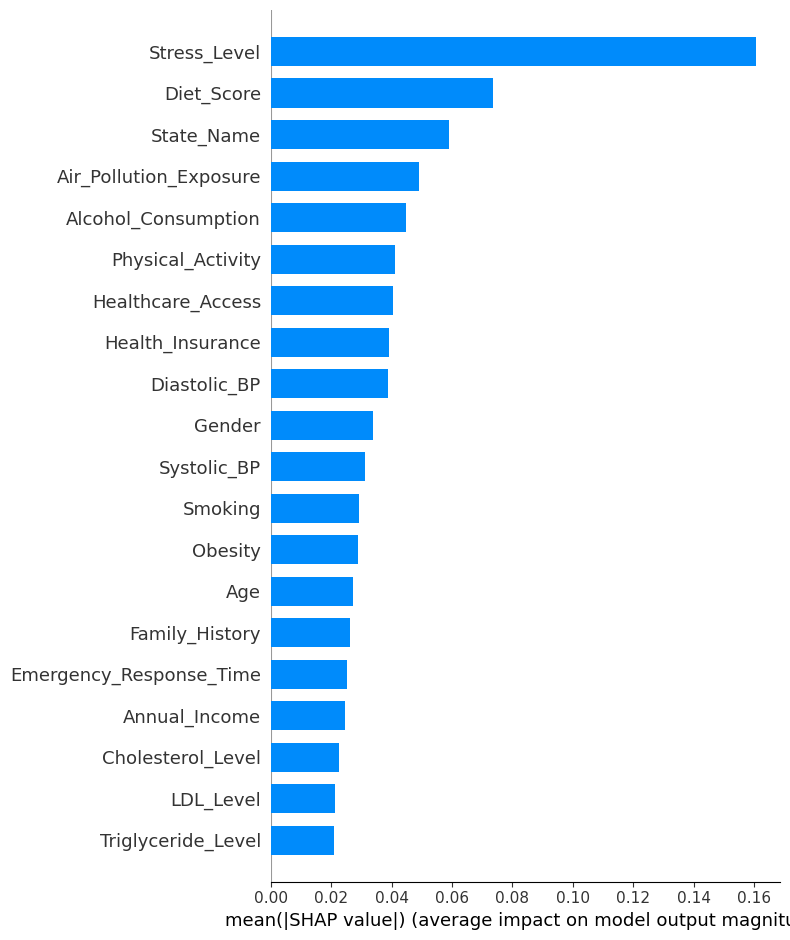

Top SHAP feature (Indian dataset): Stress_Level


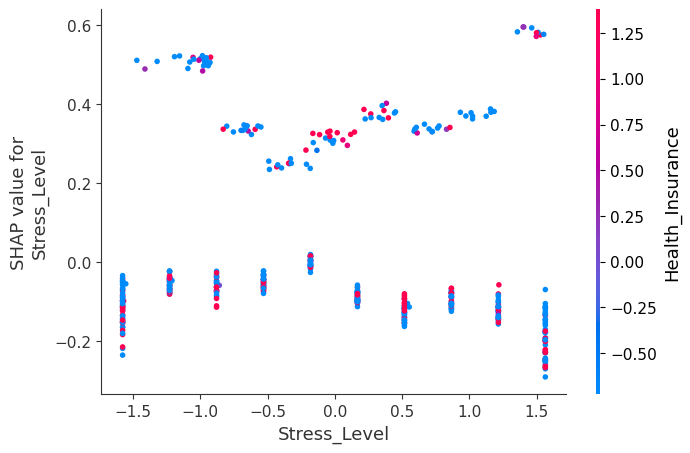

✅ FAST SHAP explainability completed successfully.
📁 Saved inside folder: SHAP_Plots_Indian


In [94]:
# =========================================================
# 🔍 FAST SHAP Explainability — RF + XGB (Indian Dataset)
# (FINAL FIX: feature names recovered from df)
# =========================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
# Recover feature names SAFELY from df
# ---------------------------------------------------------
target_col = "Heart_Attack_Risk"   # already used in your notebook
feature_names = df.drop(columns=[target_col]).columns.tolist()

# Reconstruct DataFrame after SMOTE
X_full = pd.DataFrame(X_data, columns=feature_names)
y_full = y_data

print("✔ Feature names restored correctly:")
print(feature_names)

# ---------------------------------------------------------
# Use representative sample for SHAP (FAST)
# ---------------------------------------------------------
SHAP_SAMPLE_SIZE = 500

if len(X_full) > SHAP_SAMPLE_SIZE:
    X_shap = X_full.sample(SHAP_SAMPLE_SIZE, random_state=42)
else:
    X_shap = X_full.copy()

print(f"✔ SHAP computed on {len(X_shap)} samples")

# ---------------------------------------------------------
# Load & Train Final Models (FULL DATA)
# ---------------------------------------------------------
model_pool = get_model_pool()

rf = model_pool['RF']
xgb = model_pool['XGB']

rf.fit(X_full, y_full)
xgb.fit(X_full, y_full)

print("✔ Models trained for SHAP interpretation.")

# ---------------------------------------------------------
# SHAP for Random Forest
# ---------------------------------------------------------
explainer_rf = shap.TreeExplainer(rf)
rf_vals = explainer_rf.shap_values(X_shap)

# sklearn RF → (n_samples, n_features, n_classes)
if isinstance(rf_vals, np.ndarray) and rf_vals.ndim == 3:
    rf_vals = rf_vals[:, :, 1]

# ---------------------------------------------------------
# SHAP for XGBoost
# ---------------------------------------------------------
explainer_xgb = shap.TreeExplainer(xgb)
xgb_vals = explainer_xgb.shap_values(X_shap)

if isinstance(xgb_vals, list):
    xgb_vals = xgb_vals[1]

# ---------------------------------------------------------
# Ensemble SHAP
# ---------------------------------------------------------
ensemble_shap = (rf_vals + xgb_vals) / 2
print("✔ Ensemble SHAP computed")

# ---------------------------------------------------------
# Directory to save plots
# ---------------------------------------------------------
save_dir = "SHAP_Plots_Indian"
os.makedirs(save_dir, exist_ok=True)

# =========================================================
# 1️⃣ SHAP SUMMARY PLOT
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X_shap,
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Summary_Beeswarm_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

# =========================================================
# 2️⃣ SHAP FEATURE IMPORTANCE (BAR)
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X_shap,
    plot_type="bar",
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Feature_Importance_Bar_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

# =========================================================
# 3️⃣ SHAP DEPENDENCE PLOT — TOP FEATURE
# =========================================================
mean_abs = np.mean(np.abs(ensemble_shap), axis=0)
top_feature = feature_names[np.argmax(mean_abs)]

print("Top SHAP feature (Indian dataset):", top_feature)

shap.dependence_plot(
    top_feature,
    ensemble_shap,
    X_shap,
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Dependence_{top_feature}_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("✅ FAST SHAP explainability completed successfully.")
print("📁 Saved inside folder:", save_dir)


Removing State_Name at column index: 0
✔ Final feature count: 23
✔ Feature names used for SHAP:
['Age', 'Gender', 'Diabetes', 'Hypertension', 'Obesity', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity', 'Diet_Score', 'Cholesterol_Level', 'Triglyceride_Level', 'LDL_Level', 'HDL_Level', 'Systolic_BP', 'Diastolic_BP', 'Air_Pollution_Exposure', 'Family_History', 'Stress_Level', 'Healthcare_Access', 'Heart_Attack_History', 'Emergency_Response_Time', 'Annual_Income', 'Health_Insurance']
✔ SHAP computed on 1000 samples
✔ Models trained for SHAP interpretation.
✔ Ensemble SHAP computed


C:\Users\hp\AppData\Local\Temp\ipykernel_9696\1298506318.py:103: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


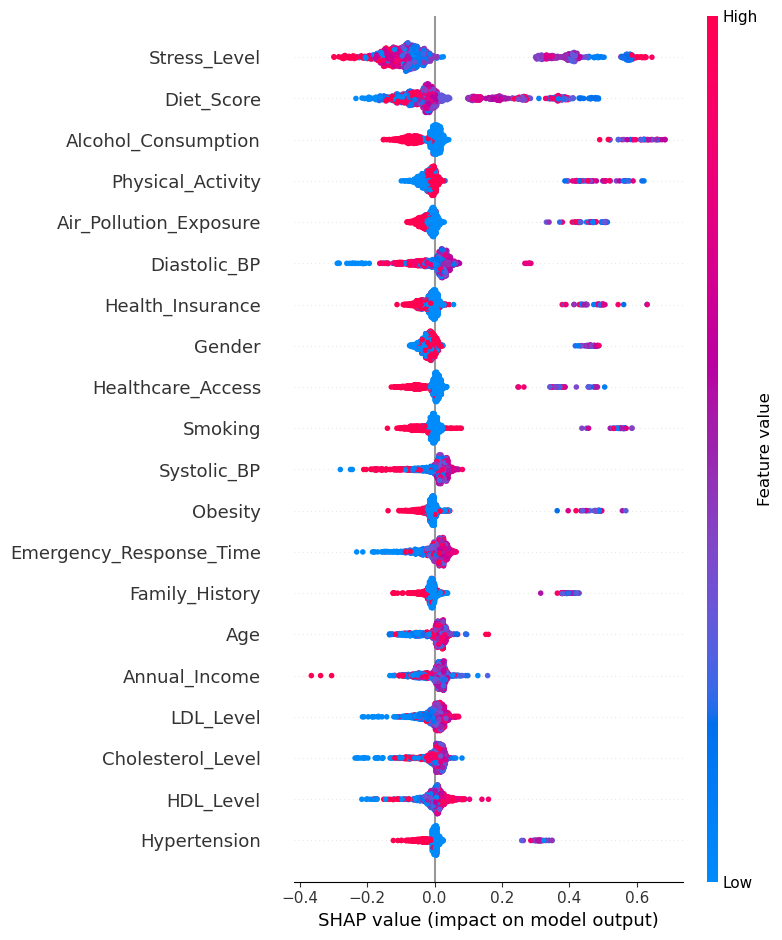

C:\Users\hp\AppData\Local\Temp\ipykernel_9696\1298506318.py:115: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


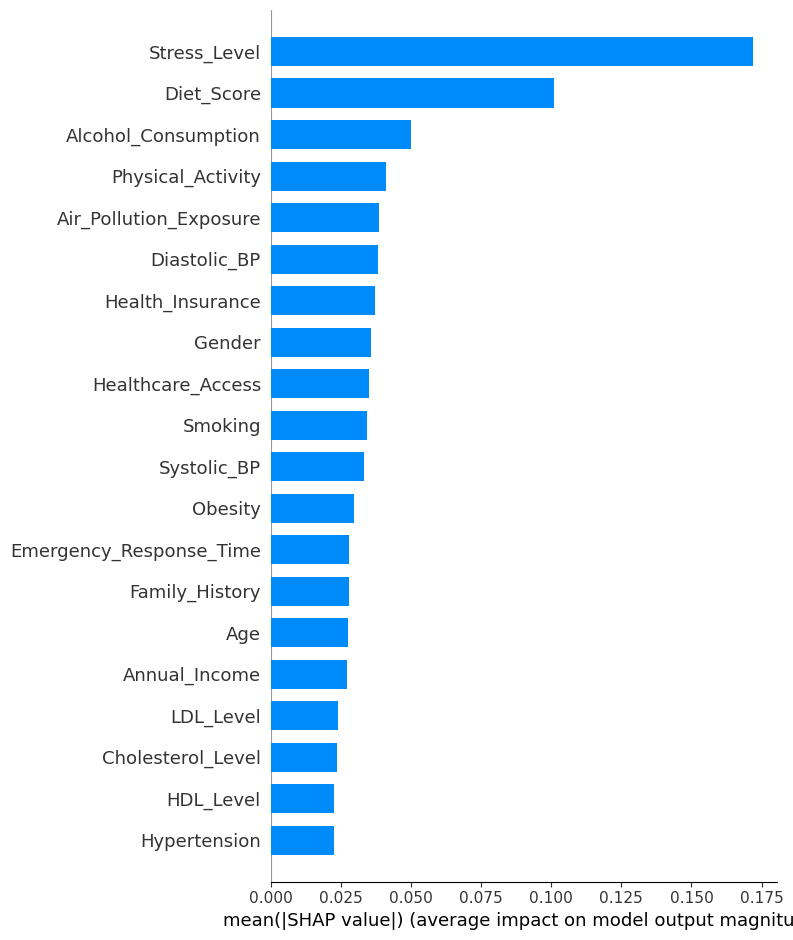

Top SHAP feature (Indian dataset): Stress_Level


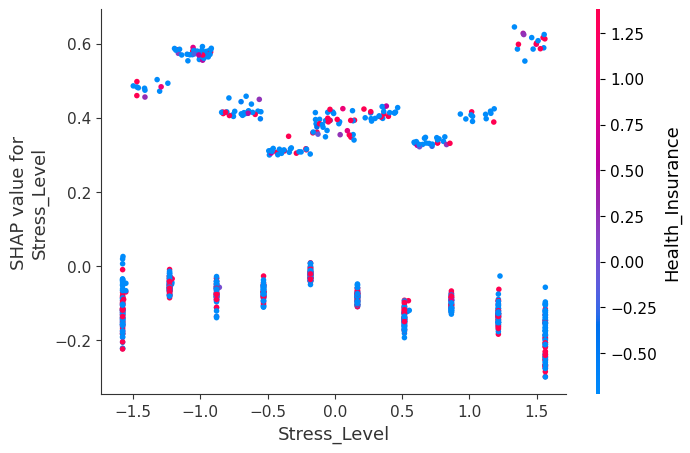

✅ SHAP completed successfully with State_Name fully excluded.


In [98]:
# =========================================================
# 🔍 FAST SHAP Explainability — RF + XGB (Indian Dataset)
# (State_Name removed CONSISTENTLY)
# =========================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
# Identify feature columns BEFORE scaling/SMOTE
# ---------------------------------------------------------
target_col = "Heart_Attack_Risk"

original_features = df.drop(columns=[target_col]).columns.tolist()

# ---------------------------------------------------------
# Remove State_Name from BOTH features and X_data
# ---------------------------------------------------------
if "State_Name" in original_features:
    state_idx = original_features.index("State_Name")
    print("Removing State_Name at column index:", state_idx)

    # Remove column from X_data
    X_data_filtered = np.delete(X_data, state_idx, axis=1)

    # Remove name
    feature_names = [f for f in original_features if f != "State_Name"]
else:
    X_data_filtered = X_data
    feature_names = original_features

# ---------------------------------------------------------
# Reconstruct DataFrame safely
# ---------------------------------------------------------
X_full = pd.DataFrame(X_data_filtered, columns=feature_names)
y_full = y_data

print("✔ Final feature count:", X_full.shape[1])
print("✔ Feature names used for SHAP:")
print(feature_names)

# ---------------------------------------------------------
# Use representative sample for SHAP (FAST)
# ---------------------------------------------------------
SHAP_SAMPLE_SIZE = 1000

if len(X_full) > SHAP_SAMPLE_SIZE:
    X_shap = X_full.sample(SHAP_SAMPLE_SIZE, random_state=42)
else:
    X_shap = X_full.copy()

print(f"✔ SHAP computed on {len(X_shap)} samples")

# ---------------------------------------------------------
# Load & Train Final Models (FULL DATA)
# ---------------------------------------------------------
model_pool = get_model_pool()

rf = model_pool['RF']
xgb = model_pool['XGB']

rf.fit(X_full, y_full)
xgb.fit(X_full, y_full)

print("✔ Models trained for SHAP interpretation.")

# ---------------------------------------------------------
# SHAP for Random Forest
# ---------------------------------------------------------
explainer_rf = shap.TreeExplainer(rf)
rf_vals = explainer_rf.shap_values(X_shap)

if isinstance(rf_vals, np.ndarray) and rf_vals.ndim == 3:
    rf_vals = rf_vals[:, :, 1]

# ---------------------------------------------------------
# SHAP for XGBoost
# ---------------------------------------------------------
explainer_xgb = shap.TreeExplainer(xgb)
xgb_vals = explainer_xgb.shap_values(X_shap)

if isinstance(xgb_vals, list):
    xgb_vals = xgb_vals[1]

# ---------------------------------------------------------
# Ensemble SHAP
# ---------------------------------------------------------
ensemble_shap = (rf_vals + xgb_vals) / 2
print("✔ Ensemble SHAP computed")

# ---------------------------------------------------------
# Directory to save plots
# ---------------------------------------------------------
save_dir = "SHAP_Plots_Indian"
os.makedirs(save_dir, exist_ok=True)

# =========================================================
# 1️⃣ SHAP SUMMARY PLOT
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X_shap,
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Summary_Beeswarm_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

# =========================================================
# 2️⃣ SHAP FEATURE IMPORTANCE (BAR)
# =========================================================
shap.summary_plot(
    ensemble_shap,
    X_shap,
    plot_type="bar",
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Feature_Importance_Bar_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

# =========================================================
# 3️⃣ SHAP DEPENDENCE PLOT — TOP FEATURE
# =========================================================
mean_abs = np.mean(np.abs(ensemble_shap), axis=0)
top_feature = feature_names[np.argmax(mean_abs)]

print("Top SHAP feature (Indian dataset):", top_feature)

shap.dependence_plot(
    top_feature,
    ensemble_shap,
    X_shap,
    show=False
)
plt.savefig(f"{save_dir}/SHAP_Dependence_{top_feature}_Indian.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("✅ SHAP completed successfully with State_Name fully excluded.")
